In [1]:
%matplotlib inline

In [2]:
import gzip

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split

from utils import effectiveDimension, factorize, gram, hiddenTargets

/Users/kristjanjonsson/Development/Notebooks/venv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## MNIST dataset

In [3]:
def parse_img(filename):
    '''Parses mnist images in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=16)
    arr = arr.astype(np.int64)
    f.close()
    return arr.reshape((-1, 28*28))

def parse_label(filename):
    '''Parses mnist labels in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=8)
    f.close()
    return arr

In [4]:
X_data = parse_img('mnist data/train-images-idx3-ubyte.gz')
y_data = parse_label('mnist data/train-labels-idx1-ubyte.gz')
print(X_data.shape, X_data.dtype)
print(y_data.shape, y_data.dtype)

(60000, 784) int64
(60000,) uint8


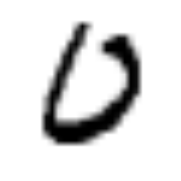

In [5]:
def plot_img(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(x.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.grid(False)
    plt.tick_params(labelbottom=False, labelleft=False)

plot_img(X_data[np.random.randint(0, len(X_data))])

In [6]:
# We'll use the 3s and 8s.
X3 = X_data[y_data == 3]
X8 = X_data[y_data == 8]
print(X3.shape)
print(X8.shape)
print()

X = np.vstack([X3, X8])
y = np.concatenate([[0] * len(X3), [1] * len(X8)])
print(X.shape)
print(y.shape)
print()


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5000)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6131, 784)
(5851, 784)

(11982, 784)
(11982,)

(5000, 784)
(5000,)
(6982, 784)
(6982,)


In [29]:
%%time
test = gram(X_train)

CPU times: user 727 ms, sys: 16.5 ms, total: 744 ms
Wall time: 736 ms


In [30]:
%%time
r = scp.linalg.eigh(test)

CPU times: user 481 ms, sys: 44 ms, total: 525 ms
Wall time: 384 ms


Label of sample image is 1


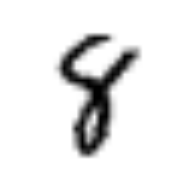

In [8]:
# Sanity check.
sampleImgIdx = np.random.randint(0, len(X_train))
sampleImg = X_train[sampleImgIdx]
sampleLabel = y_train[sampleImgIdx]
print('Label of sample image is ' + str(sampleLabel))
plot_img(sampleImg)

## Next steps
1. Plot eigenvalues as a function of i where i is the ith largest eigenvalue. Do for different $\alpha \in [0, 1]$
1. Plot $d_{95}$ (effective dimension) as a function of $\alpha$.
1. Logistic (or SVM) error as a function of $\alpha$. (note hidden targest are input an label targets). 

Question:
Throw away eigenvalues below some threshold. Not the same as $d_{95}$

In [49]:
XG = gram(X_train)
YG = gram(y_train[:, np.newaxis])

<AsyncResult: scatter>

In [210]:
alpha = 0
H, eigvals = hiddenTargets(XG, YG, alpha)
np.allclose(H.dot(H.T), alpha * XG + (1 - alpha) * YG)

True

In [56]:
effectiveDimension(eigvals)

AttributeError: 'list' object has no attribute 'sum'

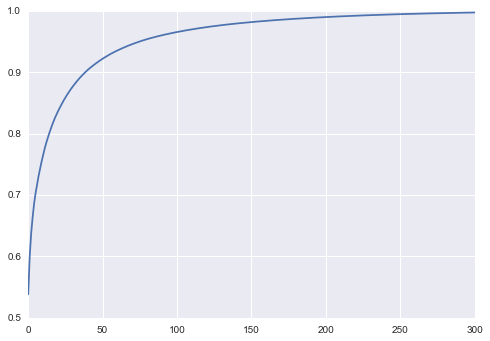

In [174]:
plt.plot(eigvals.cumsum() / eigvals.sum())
plt.xlim((0, 300));

In [35]:
ls data/1454912595

alpha_000_H.npy        alpha_035_H.npy        alpha_070_H.npy
alpha_000_eigvals.npy  alpha_035_eigvals.npy  alpha_070_eigvals.npy
alpha_005_H.npy        alpha_040_H.npy        alpha_075_H.npy
alpha_005_eigvals.npy  alpha_040_eigvals.npy  alpha_075_eigvals.npy
alpha_010_H.npy        alpha_045_H.npy        alpha_080_H.npy
alpha_010_eigvals.npy  alpha_045_eigvals.npy  alpha_080_eigvals.npy
alpha_015_H.npy        alpha_050_H.npy        alpha_085_H.npy
alpha_015_eigvals.npy  alpha_050_eigvals.npy  alpha_085_eigvals.npy
alpha_020_H.npy        alpha_055_H.npy        alpha_090_H.npy
alpha_020_eigvals.npy  alpha_055_eigvals.npy  alpha_090_eigvals.npy
alpha_025_H.npy        alpha_060_H.npy        alpha_095_H.npy
alpha_025_eigvals.npy  alpha_060_eigvals.npy  alpha_095_eigvals.npy
alpha_030_H.npy        alpha_065_H.npy        alpha_100_H.npy
alpha_030_eigvals.npy  alpha_065_eigvals.npy  alpha_100_eigvals.npy


## IO function
To help with saving and loading experiments.

In [14]:
from time import time
import os
from os.path import isdir, join
from glob import fnmatch

def filePrefix(alpha):
    '''x is a float.'''
    s = str(alpha)
    prefix = s[0] + s[2:4]
    return 'alpha_' + (prefix if len(prefix) == 3 else prefix + '0') + '_'


def createSaveDirectory():
    '''Creates a unique directory in data/ based on timestamp.'''
    directoryName = str(int(time()))
    path = join('data', directoryName)
    !mkdir $path
    assert isdir(path), 'Directory does not exist\n{0}'.format(path)
    return path

    
def save(arr, alpha, path, which): 
    '''
    arr: The numpy array to save.
    alpha: The alpha associated with this calculation. See above definition.
    path: the directory to store the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fname = join(path, filePrefix(alpha) + which)
    np.save(fname, arr)
    print('Saved: ' + fname)
  

def load(path, which):
    '''
    path: the directory of the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fnames = fnmatch.filter(os.listdir(path), '*{0}*'.format(which))
    for fname in sorted(fnames):
        fullPath = join(path, fname)
        print('Loading: {0}'.format(fullPath))
        yield np.load(fullPath)
        


In [8]:
def computeHiddenTargets(alphas, X, y):
    XG = gram(X)
    YG = gram(y[:, np.newaxis])

    path = createSaveDirectory()
    print('Saving results in dir: ' + path)
    for alpha in alphas:
        H, eigvals = hiddenTargets(XG, YG, alpha)
        save(H, alpha, path, 'H')
        save(eigvals, alpha, path, 'eigvals')
        
computeHiddenTargets(X_train, y_train, np.arange(0, 1.05, 0.05))

Saved: data/1454912595/alpha_000_H
Saved: data/1454912595/alpha_000_eigvals
Saved: data/1454912595/alpha_005_H
Saved: data/1454912595/alpha_005_eigvals
Saved: data/1454912595/alpha_010_H
Saved: data/1454912595/alpha_010_eigvals
Saved: data/1454912595/alpha_015_H
Saved: data/1454912595/alpha_015_eigvals
Saved: data/1454912595/alpha_020_H
Saved: data/1454912595/alpha_020_eigvals
Saved: data/1454912595/alpha_025_H
Saved: data/1454912595/alpha_025_eigvals
Saved: data/1454912595/alpha_030_H
Saved: data/1454912595/alpha_030_eigvals
Saved: data/1454912595/alpha_035_H
Saved: data/1454912595/alpha_035_eigvals
Saved: data/1454912595/alpha_040_H
Saved: data/1454912595/alpha_040_eigvals
Saved: data/1454912595/alpha_045_H
Saved: data/1454912595/alpha_045_eigvals
Saved: data/1454912595/alpha_050_H
Saved: data/1454912595/alpha_050_eigvals
Saved: data/1454912595/alpha_055_H
Saved: data/1454912595/alpha_055_eigvals
Saved: data/1454912595/alpha_060_H
Saved: data/1454912595/alpha_060_eigvals
Saved: data/

In [9]:
ls data

1454912595/


In [76]:
# Careful!!
# !rm -r data/*

rm: data/*: No such file or directory


In [10]:
eigvals = load('data/1454912595/', which='eigvals')

In [17]:
alphas.shape

(20,)

Loading: data/1454912595/alpha_000_eigvals.npy
Loading: data/1454912595/alpha_005_eigvals.npy
Loading: data/1454912595/alpha_010_eigvals.npy
Loading: data/1454912595/alpha_015_eigvals.npy
Loading: data/1454912595/alpha_020_eigvals.npy
Loading: data/1454912595/alpha_025_eigvals.npy
Loading: data/1454912595/alpha_030_eigvals.npy
Loading: data/1454912595/alpha_035_eigvals.npy
Loading: data/1454912595/alpha_040_eigvals.npy
Loading: data/1454912595/alpha_045_eigvals.npy
Loading: data/1454912595/alpha_050_eigvals.npy
Loading: data/1454912595/alpha_055_eigvals.npy
Loading: data/1454912595/alpha_060_eigvals.npy
Loading: data/1454912595/alpha_065_eigvals.npy
Loading: data/1454912595/alpha_070_eigvals.npy
Loading: data/1454912595/alpha_075_eigvals.npy
Loading: data/1454912595/alpha_080_eigvals.npy
Loading: data/1454912595/alpha_085_eigvals.npy
Loading: data/1454912595/alpha_090_eigvals.npy
Loading: data/1454912595/alpha_095_eigvals.npy
Loading: data/1454912595/alpha_100_eigvals.npy


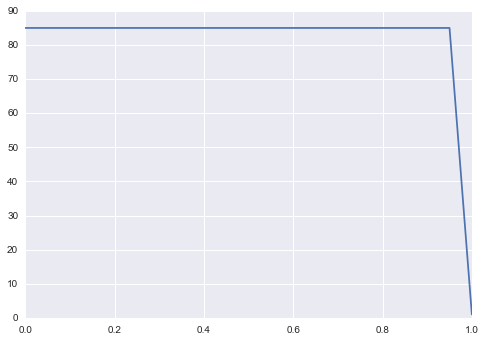

In [37]:
eigvals = load('data/1454912595/', which='eigvals')
alphas = np.arange(0, 1.05, 0.05)
p95 = np.array([effectiveDimension(eigval, p=0.95) for eigval in eigvals])
plt.plot(alphas, p95)

Loading: data/1454912595/alpha_000_eigvals.npy
Loading: data/1454912595/alpha_005_eigvals.npy
Loading: data/1454912595/alpha_010_eigvals.npy
Loading: data/1454912595/alpha_015_eigvals.npy
Loading: data/1454912595/alpha_020_eigvals.npy
Loading: data/1454912595/alpha_025_eigvals.npy
Loading: data/1454912595/alpha_030_eigvals.npy
Loading: data/1454912595/alpha_035_eigvals.npy
Loading: data/1454912595/alpha_040_eigvals.npy
Loading: data/1454912595/alpha_045_eigvals.npy
Loading: data/1454912595/alpha_050_eigvals.npy
Loading: data/1454912595/alpha_055_eigvals.npy
Loading: data/1454912595/alpha_060_eigvals.npy
Loading: data/1454912595/alpha_065_eigvals.npy
Loading: data/1454912595/alpha_070_eigvals.npy
Loading: data/1454912595/alpha_075_eigvals.npy
Loading: data/1454912595/alpha_080_eigvals.npy
Loading: data/1454912595/alpha_085_eigvals.npy
Loading: data/1454912595/alpha_090_eigvals.npy
Loading: data/1454912595/alpha_095_eigvals.npy
Loading: data/1454912595/alpha_100_eigvals.npy


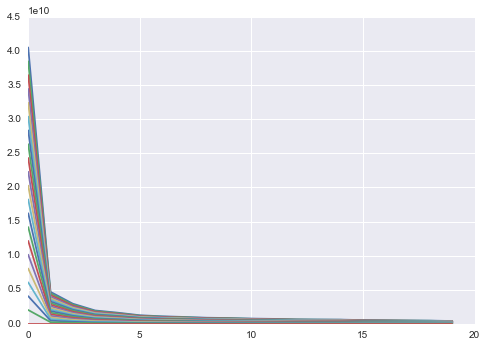

In [19]:
plt.hold(True)
for eigvals in load('data/1454912595/', which='eigvals'):
    plt.plot(eigvals[:20])
    
plt.hold(False)

Loading: data/1454912595/alpha_000_eigvals.npy
Loading: data/1454912595/alpha_005_eigvals.npy
Loading: data/1454912595/alpha_010_eigvals.npy
Loading: data/1454912595/alpha_015_eigvals.npy
Loading: data/1454912595/alpha_020_eigvals.npy
Loading: data/1454912595/alpha_025_eigvals.npy
Loading: data/1454912595/alpha_030_eigvals.npy
Loading: data/1454912595/alpha_035_eigvals.npy
Loading: data/1454912595/alpha_040_eigvals.npy
Loading: data/1454912595/alpha_045_eigvals.npy
Loading: data/1454912595/alpha_050_eigvals.npy
Loading: data/1454912595/alpha_055_eigvals.npy
Loading: data/1454912595/alpha_060_eigvals.npy
Loading: data/1454912595/alpha_065_eigvals.npy
Loading: data/1454912595/alpha_070_eigvals.npy
Loading: data/1454912595/alpha_075_eigvals.npy
Loading: data/1454912595/alpha_080_eigvals.npy
Loading: data/1454912595/alpha_085_eigvals.npy
Loading: data/1454912595/alpha_090_eigvals.npy
Loading: data/1454912595/alpha_095_eigvals.npy
Loading: data/1454912595/alpha_100_eigvals.npy


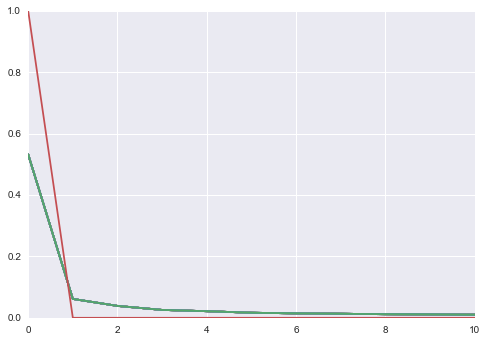

In [20]:
plt.xlim(0, 10)
plt.hold(True)
for eigvals in load('data/1454912595/', which='eigvals'):
    plt.plot(eigvals / eigvals.sum())
plt.hold(False);

In [23]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [36]:
acc_train = []
for H in load('data/1454912595/', which='H'):
    print(H.shape)
    model = LogisticRegression(C=1e6)
#     model.fit(H, y)
#     acc_train.append((model.predict(H) == y).mean())

Loading: data/1454912595/alpha_000_H.npy
(11982, 6403)
Loading: data/1454912595/alpha_005_H.npy
(11982, 6620)
Loading: data/1454912595/alpha_010_H.npy
(11982, 5998)
Loading: data/1454912595/alpha_015_H.npy
(11982, 6770)
Loading: data/1454912595/alpha_020_H.npy
(11982, 6046)
Loading: data/1454912595/alpha_025_H.npy
(11982, 6269)
Loading: data/1454912595/alpha_030_H.npy
(11982, 6313)
Loading: data/1454912595/alpha_035_H.npy
(11982, 5666)
Loading: data/1454912595/alpha_040_H.npy
(11982, 6721)
Loading: data/1454912595/alpha_045_H.npy
(11982, 6334)
Loading: data/1454912595/alpha_050_H.npy
(11982, 6252)
Loading: data/1454912595/alpha_055_H.npy
(11982, 5966)
Loading: data/1454912595/alpha_060_H.npy
(11982, 6047)
Loading: data/1454912595/alpha_065_H.npy
(11982, 6336)
Loading: data/1454912595/alpha_070_H.npy
(11982, 6800)
Loading: data/1454912595/alpha_075_H.npy
(11982, 6423)
Loading: data/1454912595/alpha_080_H.npy
(11982, 6023)
Loading: data/1454912595/alpha_085_H.npy
(11982, 6721)
Loading: d

In [38]:
import sklearn.linear_model.LogisticRegression

(11982, 784)

Schedule Rob
Mondays: Anytime
Wednesdays: anytime. 
Thursdays: 12:30 - 1:45, 3:30 - 4:45
Fridays: After surfing.